# ASE

/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopyth

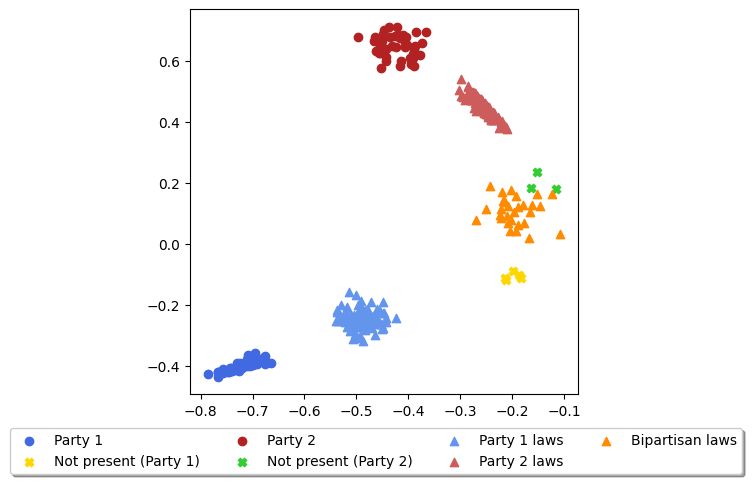

In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj, erdos_renyi_graph
from graspologic.embed import AdjacencySpectralEmbed 

## BIPARTITE
d = 4
n_P1 = 50
n_P2 = 50
n_L1 = 100
n_L2 = 100
n_L3 = 30

P1_L1 = 0.9
P1_L2 = 0.01
P1_L3 = 0.2  
P2_L1 = 0.1
P2_L2 = 0.8
P2_L3 = 0.3


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]
num_nodes = np.sum(n)

edge_index = stochastic_blockmodel_graph(n, p)

n_P1_np = 5
n_P2_np = 3
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.3).int()
    mask[i,:] = votos
    mask[:,i] = votos



adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
# ase = AdjacencySpectralEmbed(n_elbows = 2, diag_aug=True)
masked_adj = adj_matrix*mask.numpy()
x_ase = ase.fit_transform(masked_adj)
x_ase = torch.from_numpy(x_ase)
 


plt.figure(figsize=(5,5))
plt.scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
plt.scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
plt.scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
plt.scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
plt.scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
plt.scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
plt.scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()


In [2]:
A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
list_q.sort(reverse=True)
q = torch.Tensor(list_q)
q

tensor([ 1.,  1., -1., -1.])

# GD

Iteraciones:  26
Loss:  tensor(65.0529)


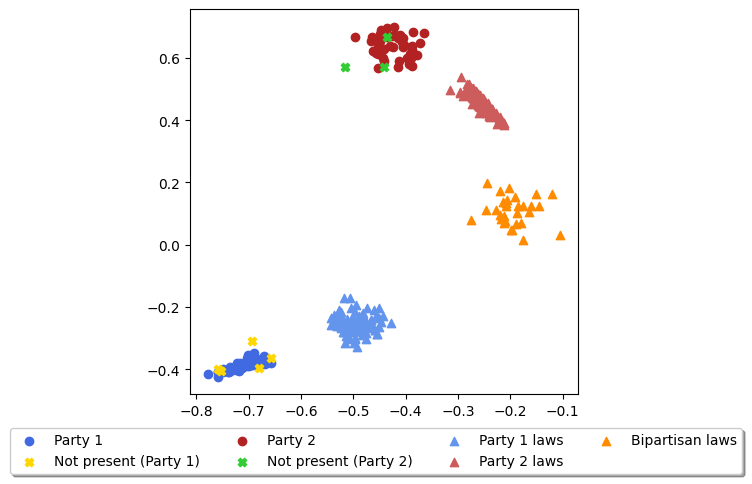

In [5]:
import sys
sys.path.append("../")

from models.RDPG_GD import GRDPG_GD_Armijo
import math
from training.get_init import get_x_init
from models.SVD_truncate import align_Xs


Q=torch.diag(q)
x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))
x_grdpg = align_Xs(x_grdpg, x_ase)



plt.figure(figsize=(5,5))
plt.scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
plt.scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
plt.scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
plt.scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
plt.scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
plt.scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
plt.scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

Iteraciones:  100
Loss:  tensor(65.0995)


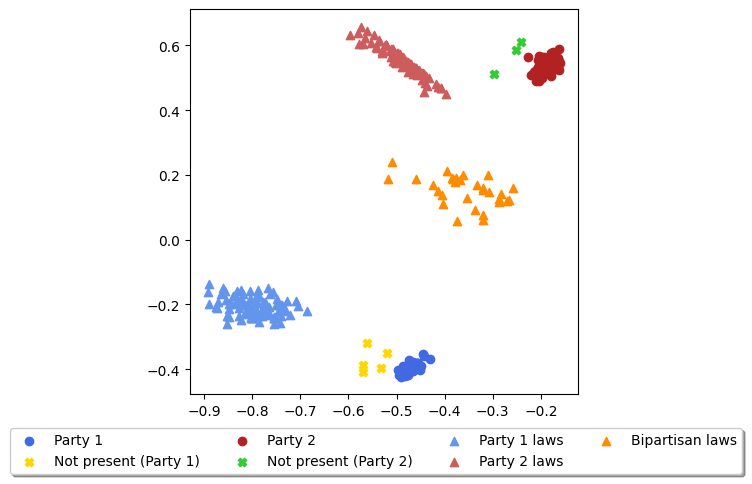

In [16]:
import sys
sys.path.append("../")

from models.RDPG_GD import GRDPG_GD_Armijo
import math
from training.get_init import get_x_init
from models.SVD_truncate import align_Xs


Q=torch.diag(q)
x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))
x_grdpg = align_Xs(x_grdpg, x_ase)


plt.figure(figsize=(5,5))
plt.scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
plt.scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
plt.scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
plt.scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
plt.scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
plt.scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
plt.scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

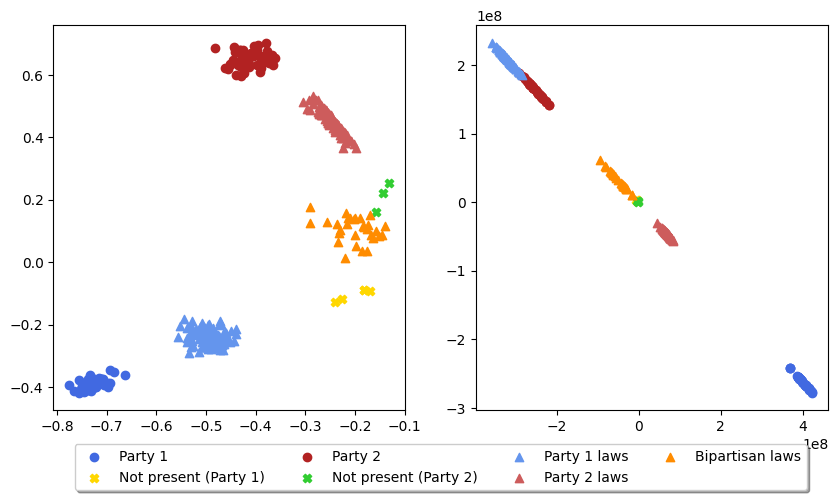

In [17]:
import sys
sys.path.append("../")

from models.GLASE_unshared_normalized import gLASE 
import math
from training.get_init import get_x_init
from models.SVD_truncate import align_Xs


Q=torch.diag(q)
gd_steps=10

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()

glase = gLASE(d, d, gd_steps)
glase.load_state_dict(torch.load('../saved_models/lase_unshared_normalized_unbalanced_bipartite_xase_d4_10steps.pt'))
glase.eval()

x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2)
x_glase = glase(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
x_glase = x_glase.detach()

x_glase = align_Xs(x_glase,x_ase)


fig, axes = plt.subplots(1, 2, figsize =(10,5))
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[1].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[1].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()


In [12]:
import sys
sys.path.append("../")

from models.GLASE_unshared_normalized import gLASE 
import math
from training.get_init import get_x_init
from models.SVD_truncate import align_Xs


Q=torch.diag(q)
gd_steps=20

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()

glase = gLASE(d, d, gd_steps)
glase.load_state_dict(torch.load('../saved_models/lase_unshared_normalized_unbalanced_bipartite_xase_20steps.pt'))
glase.eval()

x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2)
x_glase = glase(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
x_glase = x_glase.detach()

x_glase = align_Xs(x_glase,x_ase)


plt.figure(figsize=(5,5))
plt.scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
plt.scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
plt.scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
plt.scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
plt.scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
plt.scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
plt.scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

RuntimeError: Error(s) in loading state_dict for gLASE:
	size mismatch for gd.module_0.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_0.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_1.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_1.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_2.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_2.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_3.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_3.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_4.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_4.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_5.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_5.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_6.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_6.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_7.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_7.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_8.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_8.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_9.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_9.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_10.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_10.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_11.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_11.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_12.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_12.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_13.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_13.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_14.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_14.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_15.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_15.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_16.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_16.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_17.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_17.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_18.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_18.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_19.lin1.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).
	size mismatch for gd.module_19.lin2.weight: copying a param with shape torch.Size([5, 5]) from checkpoint, the shape in current model is torch.Size([4, 4]).

# ASE - d=6

# LASE - d=4

In [1]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
import matplotlib.pyplot as plt

torch.manual_seed(42)

d = 4
n_P1 = 50
n_P2 = 50
n_L1 = 100
n_L2 = 100
n_L3 = 30

P1_L1 = 0.9
P1_L2 = 0.01
P1_L3 = 0.2  
P2_L1 = 0.1
P2_L2 = 0.8
P2_L3 = 0.3


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 5
n_P2_np = 3
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.3).int()
    mask[i,:] = votos
    mask[:,i] = votos


## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask.numpy()
x_ase = ase.fit_transform(masked_adj)
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)


torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index).squeeze(0))*mask)



x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))




/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sofia/lase/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopyth

tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  100
Loss:  tensor(65.2569)


In [4]:
gd_steps = 10
lr = 1e-4
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 500

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)


tensor(66.6027, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(66.1361, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(65.3869, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(65.2807, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(65.2742, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


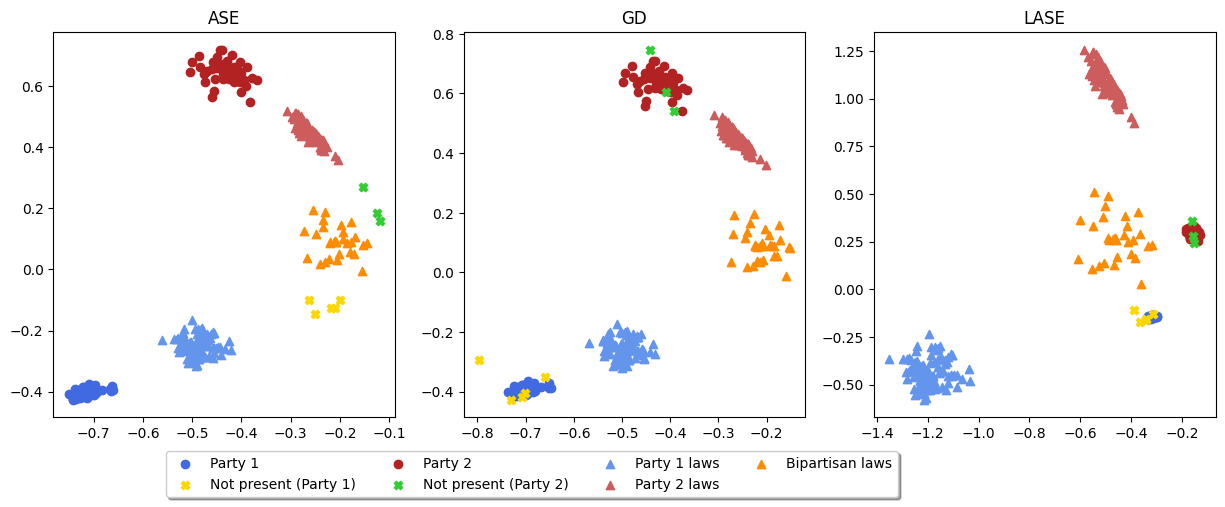

In [5]:
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

# out = align_Xs(out, x_ase.to('cpu'))

fig, axes = plt.subplots(1, 3, figsize =(15,5))
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[0].set_title('ASE')

axes[1].scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].set_title('GD')

axes[2].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[2].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[2].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[2].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[2].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[2].set_title('LASE')
plt.legend(loc='upper center', bbox_to_anchor=(-1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

### GAT Classifier

In [25]:
labels = np.concatenate((np.ones(n_P1)*0,np.ones(n_P2), np.ones(n_L1)*2, np.ones(n_L2)*3, np.ones(n_L3)*4))
labels = labels.tolist()
labels = torch.tensor(labels)


In [29]:
import random 
from models.glase_classifier import MultiLayerPerceptron
from torch import nn
from models.early_stopper import EarlyStopper

device = 'cuda'

x_glase = x_glase.to(device)
labels = labels.to(device)
num_train = int(0.7*num_nodes)
num_val = int(0.2*num_nodes)
num_test = num_nodes - num_train - num_val

indexes = list(range(num_nodes))
random.shuffle(indexes)

train_idx = indexes[:num_train]
val_idx = indexes[num_train:num_train+num_val]
test_idx = indexes[num_train + num_val:]




embedding_dim = 4  # dimensionality of the graph embeddings
h_embedding_dim = 10
output_dim = 5  # number of classes
n_layers = 3
dropout = 0.5
epochs = 200
lr=1e-2



model = MultiLayerPerceptron(embedding_dim, h_embedding_dim, output_dim, n_layers, dropout)
model.to(device)    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=10, min_delta=0)

train_loss_epoch=[]
val_loss_epoch=[]
test_loss_epoch=[]
best_valid_acc = 0
best_epoch = 0

# start = time.time()

for epoch in range(epochs):
    ## Train
    model.train()
    optimizer.zero_grad()
    out = model(x_glase[train_idx])
    loss =  criterion(out, labels[train_idx].squeeze().long())

    loss.backward() 
    optimizer.step() 
    
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_train_correct = (predicted_labels.squeeze() == labels[train_idx]).sum().item()
    total_train_samples = num_train
    train_acc = total_train_correct / total_train_samples
    total_train_loss = loss.item()    

    ## Val
    model.eval()
    out = model(x_glase[val_idx])
    loss =  criterion(out, labels[val_idx].squeeze().long())
        
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_val_correct = (predicted_labels.squeeze() == labels[val_idx]).sum().item()
    total_val_samples = num_val
    valid_acc = total_val_correct / total_val_samples
    total_val_loss = loss.item()        
    
    ## Test
    model.eval()
    out = model(x_glase[test_idx])
    loss =  criterion(out, labels[test_idx].squeeze().long())
    
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_test_correct = (predicted_labels.squeeze() == labels[test_idx]).sum().item()
    total_test_samples = num_test
    test_acc = total_test_correct / total_test_samples
    total_test_loss = loss.item()     
           
    train_loss_epoch.append(total_train_loss)
    val_loss_epoch.append(total_val_loss)
    test_loss_epoch.append(total_test_loss)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        # torch.save(model.state_dict(), MODEL_FILE)
        best_epoch = epoch
    
    # Print epoch statistics
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {total_train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

print(best_epoch)


Epoch: 00, Loss: 1.7280, Train: 25.22%, Valid: 43.94% Test: 26.47%
Epoch: 01, Loss: 1.6886, Train: 19.57%, Valid: 43.94% Test: 26.47%
Epoch: 02, Loss: 1.6646, Train: 23.91%, Valid: 43.94% Test: 26.47%
Epoch: 03, Loss: 1.6471, Train: 24.78%, Valid: 43.94% Test: 26.47%
Epoch: 04, Loss: 1.6144, Train: 22.61%, Valid: 43.94% Test: 26.47%
Epoch: 05, Loss: 1.6132, Train: 26.09%, Valid: 43.94% Test: 26.47%
Epoch: 06, Loss: 1.5879, Train: 25.65%, Valid: 43.94% Test: 26.47%
Epoch: 07, Loss: 1.5601, Train: 26.09%, Valid: 43.94% Test: 26.47%
Epoch: 08, Loss: 1.5419, Train: 28.26%, Valid: 43.94% Test: 26.47%
Epoch: 09, Loss: 1.5309, Train: 29.57%, Valid: 43.94% Test: 26.47%
Epoch: 10, Loss: 1.5147, Train: 35.22%, Valid: 43.94% Test: 26.47%
Epoch: 11, Loss: 1.4929, Train: 37.39%, Valid: 43.94% Test: 26.47%
Epoch: 12, Loss: 1.4338, Train: 39.57%, Valid: 43.94% Test: 26.47%
Epoch: 13, Loss: 1.4363, Train: 36.09%, Valid: 43.94% Test: 26.47%
Epoch: 14, Loss: 1.4344, Train: 35.65%, Valid: 62.12% Test: 61

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you have a simple MLP network
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

# Define your model, loss function, and optimizer
input_size = 10
hidden_size = 64
output_size = 5  # Number of classes
model = SimpleMLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Generate some dummy data
num_samples = 100
input_data = torch.randn(num_samples, input_size)
target_labels = torch.randint(0, output_size, (num_samples,))

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(input_data)
    
    # Compute the loss
    loss = criterion(outputs, target_labels)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# After training, you can use the model for predictions
# For example, you can do:
test_data = torch.randn(1, input_size)  # Dummy test data
with torch.no_grad():
    model.eval()
    predictions = model(test_data)
    predicted_class = torch.argmax(predictions, dim=1).item()
    print(f"Predicted class: {predicted_class}")


Epoch 1/10, Loss: 1.6067988872528076
Epoch 2/10, Loss: 1.6051031351089478
Epoch 3/10, Loss: 1.6034244298934937
Epoch 4/10, Loss: 1.6017625331878662
Epoch 5/10, Loss: 1.600117802619934
Epoch 6/10, Loss: 1.5984890460968018
Epoch 7/10, Loss: 1.596876859664917
Epoch 8/10, Loss: 1.5952802896499634
Epoch 9/10, Loss: 1.5936994552612305
Epoch 10/10, Loss: 1.5921341180801392
Predicted class: 0


In [7]:
target_labels.shape

torch.Size([100])

## x random

In [160]:
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)


In [166]:
gd_steps = 10
lr = 1e-1
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 2000

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
x = torch.rand(num_nodes,d).to(device)

edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)


tensor(224.2935, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(nan, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


KeyboardInterrupt: 

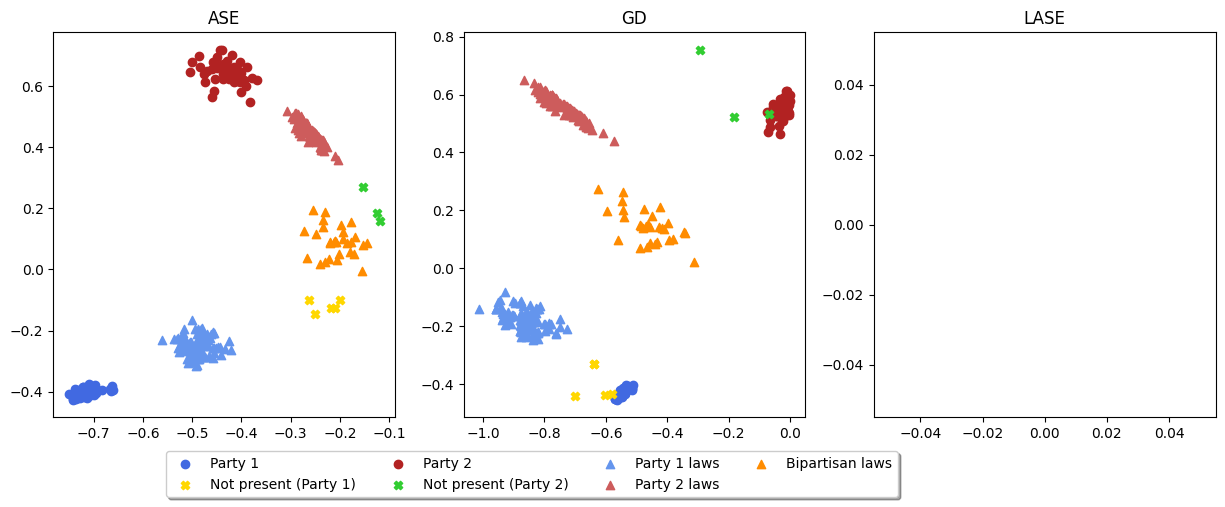

In [128]:
out = out.detach().to('cpu')
x_ase = x_ase.to('cpu')
x_grdpg = x_grdpg.to('cpu')

x_grdpg = align_Xs(x_grdpg, x_ase)
# out = align_Xs(out, x_ase)

fig, axes = plt.subplots(1, 3, figsize =(15,5))
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[0].set_title('ASE')

axes[1].scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].set_title('GD')

axes[2].scatter(out[n_P1_np:n_P1,0],out[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[2].scatter(out[:n_P1_np,0],out[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[2].scatter(out[n_P1+n_P2_np:n_P1+n_P2,0],out[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[2].scatter(out[n_P1:n_P1+n_P2_np,0],out[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[2].scatter(out[n_P1+n_P2:n_P1+n_P2+n_L1,0],out[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[2].scatter(out[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],out[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[2].scatter(out[n_P1+n_P2+n_L1+n_L2:,0],out[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[2].set_title('LASE')
plt.legend(loc='upper center', bbox_to_anchor=(-1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()